In [2]:
# ========== A) SETUP ==========
import numpy as np
import random
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(42)
random.seed(42)


In [4]:
# ========== B) MAZE ENVIRONMENT ==========
# Grid encoding:
# 0 = free cell
# 1 = wall
# S = start (given as coordinate)
# G = goal (given as coordinate)

class MazeEnv:
    def __init__(self, grid, start, goal):
        """
        grid: 2D numpy array with 0=free, 1=wall
        start, goal: (row, col)
        """
        self.grid = np.array(grid, dtype=int)
        self.n_rows, self.n_cols = self.grid.shape
        self.start = start
        self.goal = goal
        self.state = start
        self.done = False

        # Up, Right, Down, Left
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.action_space = len(self.actions)

    def reset(self):
        self.state = self.start
        self.done = False
        return self.state

    def in_bounds(self, r, c):
        return 0 <= r < self.n_rows and 0 <= c < self.n_cols

    def step(self, action):
        """
        action: int in {0,1,2,3}
        Returns: next_state, reward, done, info
        Rewards:
          +1.0 on reaching goal
          -0.01 each step to encourage shorter paths
          -0.1 if you try to walk into a wall (stay in place)
        """
        if self.done:
            raise ValueError("Episode is done. Call reset().")

        dr, dc = self.actions[action]
        r, c = self.state
        nr, nc = r + dr, c + dc

        reward = -0.01
        next_state = self.state  # default: stay

        if self.in_bounds(nr, nc) and self.grid[nr, nc] == 0:
            next_state = (nr, nc)
        else:
            # bumping walls or out of bounds
            reward -= 0.09

        self.state = next_state

        if self.state == self.goal:
            reward = 1.0
            self.done = True

        return self.state, reward, self.done, {}

    def state_to_index(self, s):
        return s[0] * self.n_cols + s[1]

    def index_to_state(self, idx):
        return (idx // self.n_cols, idx % self.n_cols)

    def available_actions(self, s):
        # All 4 actions are always possible; walls handled in step() with penalty.
        return [0, 1, 2, 3]

    def render(self, path=None):
        """
        Print the grid. Optionally overlay a path (list of states).
        """
        grid_disp = np.array(self.grid, dtype=object)
        grid_disp[:] = ' '
        grid_disp[self.grid == 1] = '#'
        sr, sc = self.start
        gr, gc = self.goal
        grid_disp[sr, sc] = 'S'
        grid_disp[gr, gc] = 'G'

        if path:
            for (r, c) in path:
                if (r, c) not in [self.start, self.goal]:
                    grid_disp[r, c] = '.'

        print("\n".join("".join(row) for row in grid_disp))
        print()


In [6]:
# ========== C) DEFINE A MAZE ==========
# 0 = free, 1 = wall
grid = [
    [0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 0],
    [0, 1, 0, 0, 1, 0],
    [0, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0],
]
start = (0, 0)
goal  = (4, 5)

env = MazeEnv(grid, start, goal)
env.render()


S     
 ## # 
 #  # 
 # ## 
     G



In [8]:
# ========== D) Q-LEARNING AGENT ==========
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.6, gamma=0.99,
                 epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.999):
        self.Q = np.zeros((n_states, n_actions), dtype=float)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.n_actions = n_actions

    def choose_action(self, state_idx):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return int(np.argmax(self.Q[state_idx]))

    def update(self, s, a, r, s_next, done):
        best_next = 0.0 if done else np.max(self.Q[s_next])
        td_target = r + self.gamma * best_next
        td_error = td_target - self.Q[s, a]
        self.Q[s, a] += self.alpha * td_error

    def decay_eps(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [10]:
# ========== E) TRAINING LOOP ==========
n_states = env.n_rows * env.n_cols
agent = QLearningAgent(n_states=n_states, n_actions=env.action_space,
                       alpha=0.6, gamma=0.99,
                       epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.999)

episodes = 8000
rewards_per_ep = []

for ep in range(1, episodes + 1):
    s = env.reset()
    s_idx = env.state_to_index(s)
    ep_reward = 0.0

    for t in range(500):  # cap steps/episode
        a = agent.choose_action(s_idx)
        s_next, r, done, _ = env.step(a)
        s_next_idx = env.state_to_index(s_next)

        agent.update(s_idx, a, r, s_next_idx, done)
        ep_reward += r

        s_idx = s_next_idx
        if done:
            break

    agent.decay_eps()
    rewards_per_ep.append(ep_reward)

    if ep % 1000 == 0:
        avg_last = np.mean(rewards_per_ep[-1000:])
        print(f"Episode {ep:5d} | ε={agent.epsilon:.3f} | avg reward(last 1000)={avg_last:.3f}")

print("Training done!")


Episode  1000 | ε=0.368 | avg reward(last 1000)=-0.506
Episode  2000 | ε=0.135 | avg reward(last 1000)=0.782
Episode  3000 | ε=0.050 | avg reward(last 1000)=0.875
Episode  4000 | ε=0.050 | avg reward(last 1000)=0.895
Episode  5000 | ε=0.050 | avg reward(last 1000)=0.896
Episode  6000 | ε=0.050 | avg reward(last 1000)=0.898
Episode  7000 | ε=0.050 | avg reward(last 1000)=0.895
Episode  8000 | ε=0.050 | avg reward(last 1000)=0.896
Training done!


In [12]:
# ========== F) EXTRACT GREEDY POLICY & SHORTEST PATH ==========
def greedy_policy_path(env, Q):
    """
    Roll out a greedy path from start to goal using learned Q.
    Returns: path (list of states), total_reward
    """
    s = env.reset()
    s_idx = env.state_to_index(s)
    path = [s]
    total_reward = 0.0

    # disable randomness by acting greedily
    for _ in range(500):
        a = int(np.argmax(Q[s_idx]))
        s_next, r, done, _ = env.step(a)
        total_reward += r
        path.append(s_next)
        s_idx = env.state_to_index(s_next)
        if done:
            break
    return path, total_reward

path, tr = greedy_policy_path(env, agent.Q)
print("Greedy path length:", len(path))
print("Total reward along path:", tr)
env.render(path=path)


Greedy path length: 10
Total reward along path: 0.92
S.....
 ## #.
 #  #.
 # ##.
     G



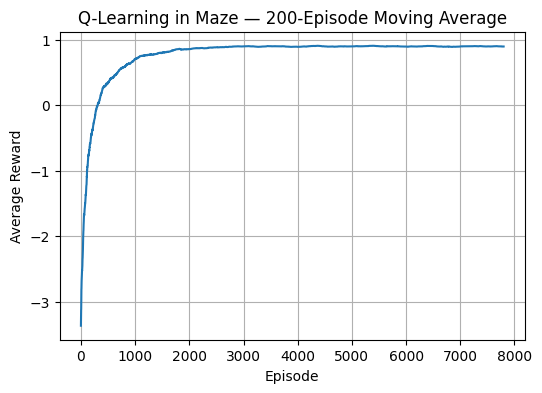

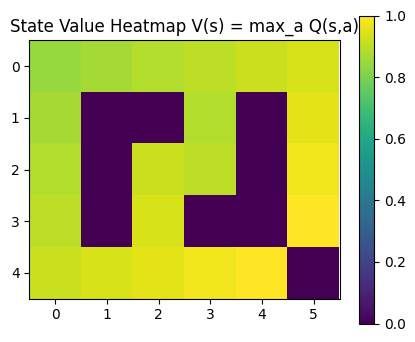

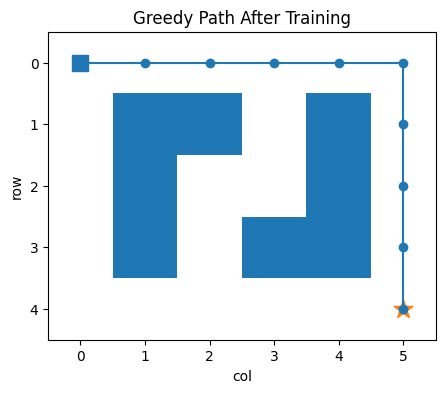

In [14]:
# ========== G) SIMPLE VISUALIZATIONS ==========
# 1) Learning curve (moving average of rewards)
window = 200
if len(rewards_per_ep) >= window:
    mov_avg = np.convolve(rewards_per_ep, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(6,4))
    plt.plot(mov_avg)
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.title(f"Q-Learning in Maze — {window}-Episode Moving Average")
    plt.grid(True)
    plt.show()

# 2) State value heatmap V(s) = max_a Q(s,a)
V = agent.Q.max(axis=1).reshape(env.n_rows, env.n_cols)

plt.figure(figsize=(5,4))
plt.imshow(V, aspect='equal')
plt.colorbar()
plt.title("State Value Heatmap V(s) = max_a Q(s,a)")
plt.xticks(range(env.n_cols))
plt.yticks(range(env.n_rows))
plt.show()

# 3) Plot the greedy path on a grid
fig, ax = plt.subplots(figsize=(5,4))
# draw walls
for r in range(env.n_rows):
    for c in range(env.n_cols):
        if env.grid[r, c] == 1:
            ax.add_patch(plt.Rectangle((c-0.5, r-0.5), 1, 1))
# draw path
ys = [s[0] for s in path]
xs = [s[1] for s in path]
ax.plot(xs, ys, marker='o')
ax.scatter([start[1]], [start[0]], marker='s', s=120)
ax.scatter([goal[1]], [goal[0]], marker='*', s=200)
ax.set_xlim(-0.5, env.n_cols-0.5)
ax.set_ylim(-0.5, env.n_rows-0.5)
ax.invert_yaxis()
ax.set_xlabel("col")
ax.set_ylabel("row")
ax.set_title("Greedy Path After Training")
plt.show()
